<a href="https://colab.research.google.com/github/chetan015/deep-learning/blob/master/Session-06/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import Model
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


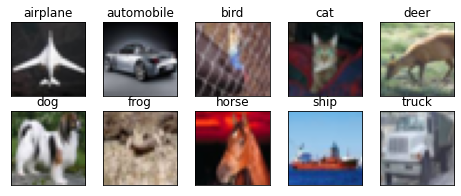

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, concatenate

In [0]:
model_input = Input(shape=(32,32,3))

# 1. Normal Convolution
# RCF 3x3
x = Conv2D(16,3,3,border_mode='same')(model_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# 2. Spatially Separable 3x3 convolution - 3x1 followed by 1x3
# RCF 5x5
x = Conv2D(32,3,1, border_mode='same')(x)
x = Conv2D(32,1,3, border_mode='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# MaxPooling
# RCF 10x10
x = MaxPooling2D(pool_size=2)(x)

# 3. Depthwise separable 3x3 convolution
# RCF 12x12
x = SeparableConv2D(32,3,3,border_mode = 'same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# 4. Grouped Convolution, with 3x3 and 5x5
# RCF 14x14,16x16
y = Convolution2D(32,3,3,border_mode='same')(x)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Dropout(0.2)(y)

z = Convolution2D(32,5,5,border_mode='same')(x)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dropout(0.2)(z)

# concatenate
x =concatenate([y,z])

# Add Max pooling, RCF 28x28+32x32
x = MaxPooling2D(pool_size=2)(x)

# 5. Grouped Convolution, twice with 3x3 dilation_rate = 1 and 2
y = Convolution2D(64,3,3,dilation_rate=1,border_mode='same')(x)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Dropout(0.2)(y)

z = Convolution2D(64,5,5,dilation_rate=2,border_mode='same')(x)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dropout(0.2)(z)

x = concatenate([y,z])

# 6. Normal Convolution
x = Convolution2D(128,3,3,border_mode='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# Reduce to ten channels
x = Convolution2D(10,1)(x)
# Add final convolution to reshape output layer to 1x10
x = Convolution2D(10,8,8)(x)
x = Flatten()(x)
output = Activation('softmax')(x)

model = Model(model_input,output)
# # Define the model
# model = Sequential()

# # RCF 3x3
# # 1. Normal Convolution
# model.add(Convolution2D(16, 3, 3, input_shape=(32, 32, 3),border_mode="same")) #32
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# # RCF 5x5
# # 2. Using spatially separable 3x3 kernel - 3x1 followed by 1x3
# model.add(Convolution2D(32, 3, 1,border_mode="same"))#32
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Convolution2D(32, 1, 3,border_mode="same"))#32
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# #Transition Block
# # RCF 10x10
# # Reduce to 16 channels
# model.add(MaxPooling2D(pool_size=(2,2))) 
# # model.add(Convolution2D(16,1))#16


# RCF 12x12
# # 3. Depthwise Separable Convolution
# model.add(SeparableConvolution2D(32, 3, 3,border_mode="same"))#16
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))


# # RCF 14x14
# model.add(Convolution2D(64, 3, 3,border_mode="same"))#16
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

#Transition Block
# RCF 28x28
# Reduce to 16 channels
# model.add(MaxPooling2D(pool_size=(2,2))) #8
# # model.add(Convolution2D(16,1))

# # RCF 30x30
# model.add(Convolution2D(64, 3, 3,border_mode="same"))#8
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# # RCF 32x32
# model.add(Convolution2D(128, 3, 3,border_mode="same"))#8
# model.add(BatchNormalization())
# model.add(Activation('relu'))


# # Reduce to ten channels
# model.add(Convolution2D(10,1))

# # Add final convolution to reshape output layer to 1x10
# model.add(Convolution2D(10, 8, 8)) #1

# model.add(Flatten())
# model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Learning Rate scheduler to find optimal learning rate
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.006 * 1/(1 + 0.319 * epoch), 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

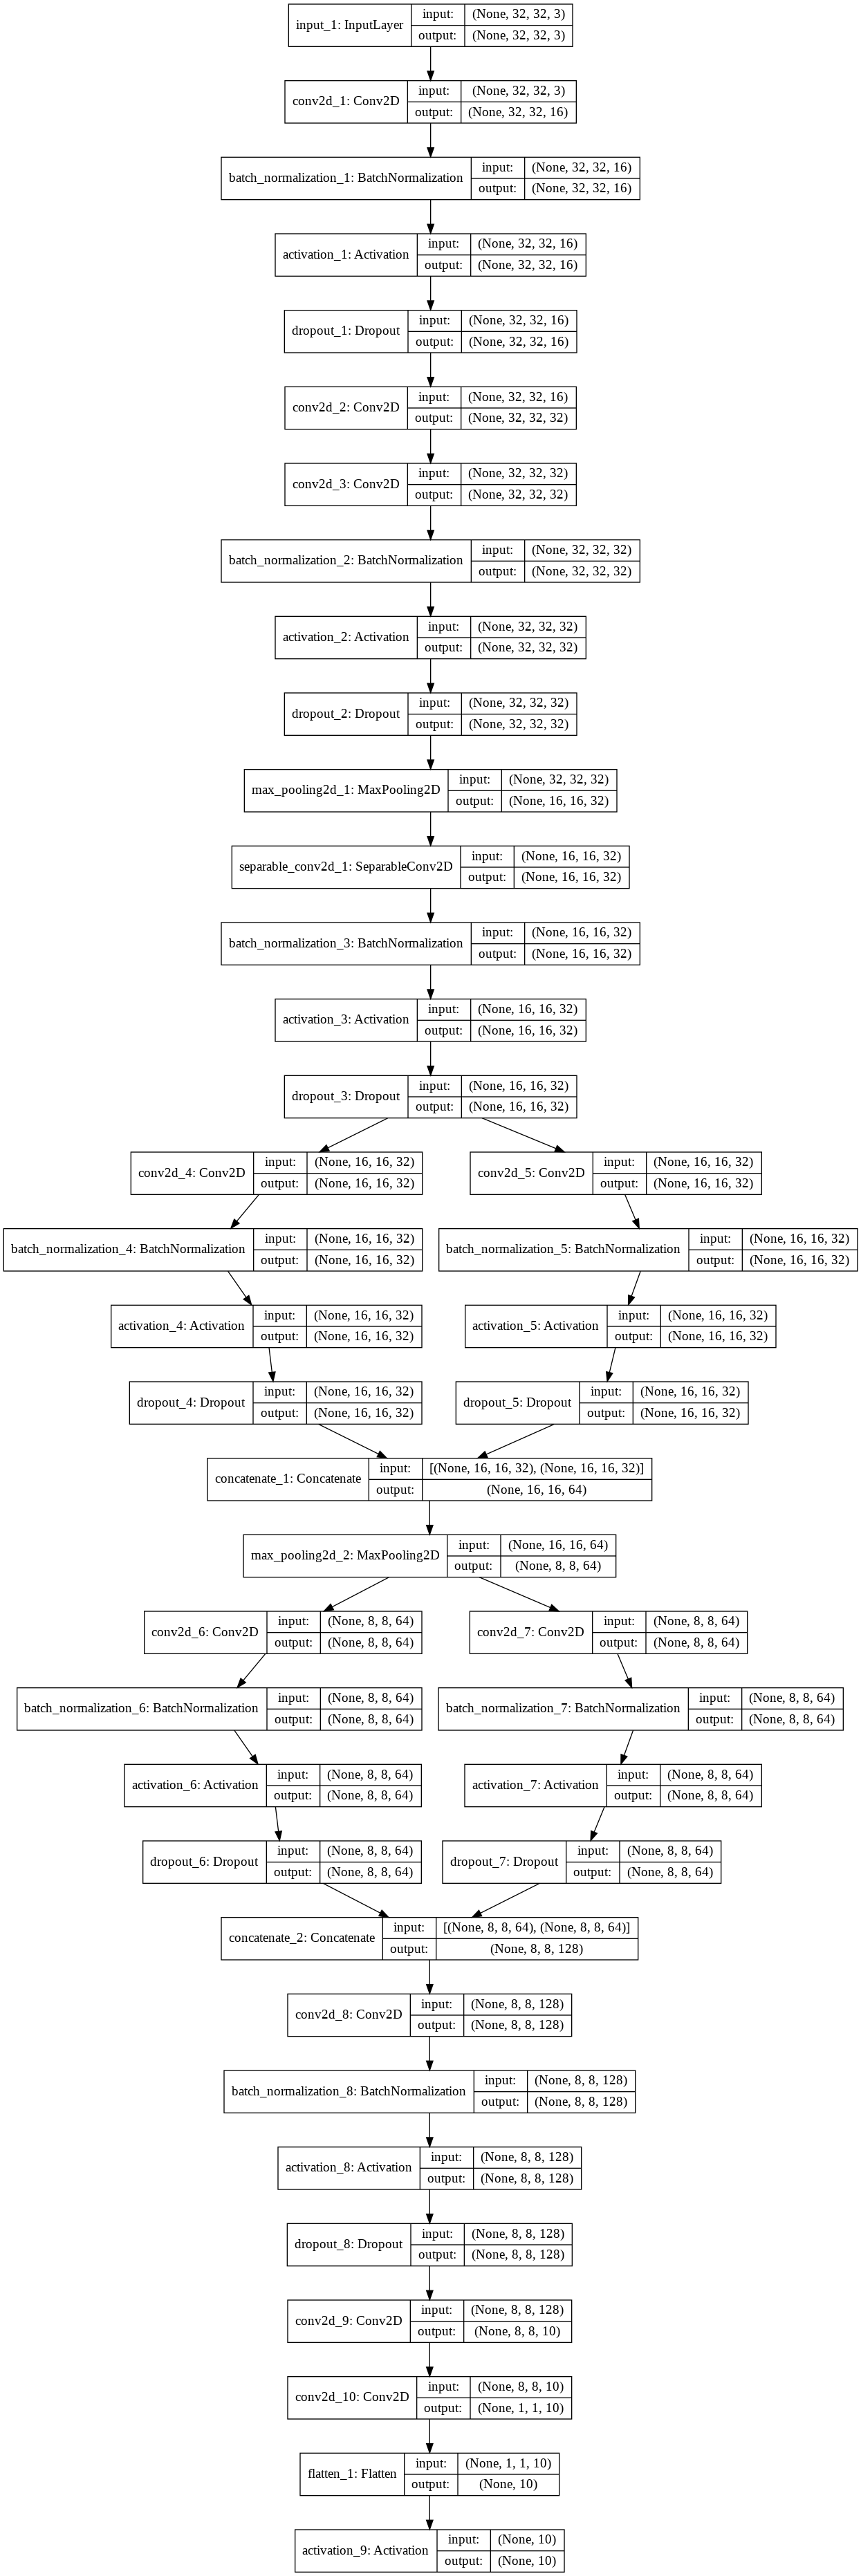

In [0]:
from keras.utils import plot_model
model.summary()
plot_model(model, 'model.png', show_shapes=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.006.
390/390 [==============================] - 25s 63ms/step - loss: 1.6673 - accuracy: 0.4008 - val_loss: 2.3747 - val_accuracy: 0.2675
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0045489007.
390/390 [==============================] - 15s 39ms/step - loss: 1.1385 - accuracy: 0.5934 - val_loss: 1.3963 - val_accuracy: 0.4980
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036630037.
390/390 [==============================] - 15s 39ms/step - loss: 0.8649 - accuracy: 0.6934 - val_loss: 1.2720 - val_accuracy: 0.5647
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0030659172.
390/390 [==============================] - 15s 39ms/step - loss: 0.7375 - accuracy: 0.7397 - val_loss: 0.7837 - val_accuracy: 0.7225
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0026362039.
390/390 [==============================] - 15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


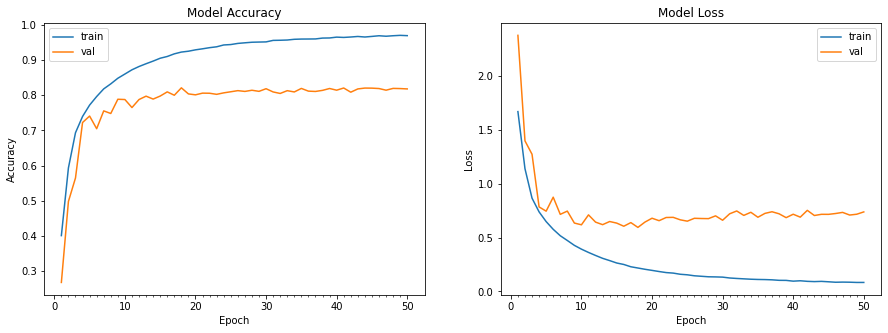

Accuracy on test data is: 81.81


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))